In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, plot_roc_curve
import warnings
import datetime
warnings.filterwarnings('ignore')
%matplotlib inline
from sklearn import metrics

# Data Import - Exploration 

In [12]:
df = pd.read_csv("covid_data.csv")
df[["human_development_index"]]
corr = df.corr()
print(corr.abs().unstack().sort_values(kind="quicksort").drop_duplicates()[-5:])

people_vaccinated      total_vaccinations         0.993701
aged_70_older          aged_65_older              0.994141
total_vaccinations     people_fully_vaccinated    0.995965
total_cases            total_cases                1.000000
weekly_icu_admissions  handwashing_facilities          NaN
dtype: float64


In [3]:
corr_matrix = df.corr().abs()
corr_matrix
corr_matrix = corr_matrix[corr_matrix > 0.5]
corr_matrix = corr_matrix[corr_matrix.index.to_list()]
corr_matrix

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
total_cases,1.000000,0.671281,0.694447,0.936471,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.614839,0.753939,NaN,NaN,NaN
new_cases,0.671281,1.000000,0.972716,0.705354,0.645232,0.632060,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.543217,NaN,NaN,NaN,NaN
new_cases_smoothed,0.694447,0.972716,1.000000,0.725595,0.639532,0.651794,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.557834,NaN,NaN,NaN,NaN
total_deaths,0.936471,0.705354,0.725595,1.000000,0.605267,0.624088,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.712860,0.926142,NaN,NaN,NaN
new_deaths,NaN,0.645232,0.639532,0.605267,1.000000,0.976632,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.685255,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
population,0.614839,0.543217,0.557834,0.712860,0.685255,0.702537,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.000000,0.746033,NaN,NaN,NaN
excess_mortality_cumulative_absolute,0.753939,NaN,NaN,0.926142,NaN,0.540006,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.746033,1.000000,NaN,NaN,NaN
excess_mortality_cumulative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.552841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.693282
excess_mortality,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN


# Feature Enginnering 

In [13]:

#too add to new table
df_fully_vaxed = pd.DataFrame({'location':[], 'percent_fully_vaccinated':[]})

visited_country = []
for i in range(len(df['location'])):
    if df['location'][i] in visited_country:
        continue
    selected_rows = df.loc[df['location'] == df['location'][i]]
    selected_rows.sort_values(by='date', ascending=False, inplace=True)
    selected_rows = selected_rows.dropna(subset=['people_fully_vaccinated'])
    population = selected_rows.loc[:, ['population']]
    people_fully_vaccinated = selected_rows.loc[:, ['people_fully_vaccinated']]
    max_pop =  population.max()
    max_fully_vax = people_fully_vaccinated.max()
    percent_fully_vaxed = max_fully_vax[0]/max_pop[0] *100
    visited_country.append(df['location'][i])
    df_fully_vaxed.loc[i] = {'location': df['location'][i], 'percent_fully_vaccinated': percent_fully_vaxed}
    #print(df['location'][i], ": ", percent_fully_vaxed)
    
#df_fully_vaxed = pd.DataFrame(data, index = data.keys())

In [10]:
df_fully_vaxed = df_fully_vaxed.dropna()
df_fully_vaxed

,location,percent_fully_vaccinated
0,Afghanistan,25.606588
1008,Africa,25.553833
2027,Albania,44.618512
3034,Algeria,14.433675
4041,Andorra,66.987713
...,...,...
233492,Wallis and Futuna,58.589169
234263,World,62.920304
235304,Yemen,2.014244
236266,Zambia,40.917150


In [15]:
#what columns using
df1_selected_columns = df[["location", "gdp_per_capita", "extreme_poverty", "handwashing_facilities", "new_cases_smoothed_per_million","human_development_index"]]
df2_selected_columns = df_fully_vaxed[["location", "percent_fully_vaccinated"]]
df_merged = pd.merge(df1_selected_columns, df2_selected_columns, on="location", how="inner")
#df_merged.fillna(0, inplace=True)
df_merged = df_merged.dropna()
df_merged = df_merged[df_merged['gdp_per_capita'].notna()]
df_merged = df_merged[df_merged['extreme_poverty'].notna()]
df_merged = df_merged[df_merged['handwashing_facilities'].notna()]
df_merged = df_merged[df_merged['new_cases_smoothed_per_million'].notna()]
df_merged = df_merged[df_merged['human_development_index'].notna()]
df_merged = df_merged[df_merged['percent_fully_vaccinated'].notna()]


In [ ]:
df_merged

# Feature Selection

In [16]:

X = df_merged[[ "extreme_poverty","handwashing_facilities","percent_fully_vaccinated","gdp_per_capita"]]
Y = df_merged[["human_development_index"]]


# Visualization 

Text(0, 0.5, 'human_development_index')

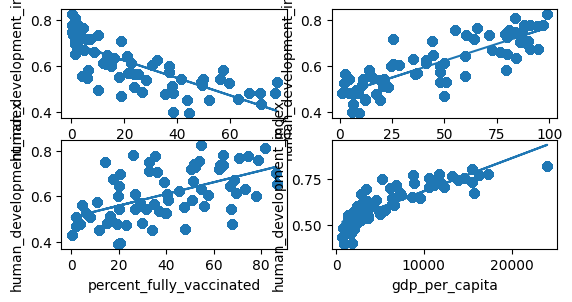

In [17]:

plt.subplot(3, 2, 1)
a,b = np.polyfit(X["extreme_poverty"],Y,1)
plt.scatter(X["extreme_poverty"],Y)
plt.plot(X["extreme_poverty"], a * X["extreme_poverty"] + b)
plt.xlabel("extreme_poverty")
plt.ylabel("human_development_index")

plt.subplot(3, 2, 2)
a,b = np.polyfit(X["handwashing_facilities"],Y,1)
plt.scatter(X["handwashing_facilities"],Y)
plt.plot(X["handwashing_facilities"], a * X["handwashing_facilities"] + b)
plt.xlabel("handwashing_facilities")
plt.ylabel("human_development_index")

plt.subplot(3, 2, 3)
a,b = np.polyfit(X["percent_fully_vaccinated"],Y,1)
plt.scatter(X["percent_fully_vaccinated"],Y)
plt.plot(X["percent_fully_vaccinated"], a * X["percent_fully_vaccinated"] + b)
plt.xlabel("percent_fully_vaccinated")
plt.ylabel("human_development_index")

plt.subplot(3, 2, 4)
a,b = np.polyfit(X["gdp_per_capita"],Y,1)
plt.scatter(X["gdp_per_capita"],Y)
plt.plot(X["gdp_per_capita"], a * X["gdp_per_capita"] + b)
plt.xlabel("gdp_per_capita")
plt.ylabel("human_development_index")



# Normalization - Model Training

In [18]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)
len(X_train)

from sklearn import preprocessing
x_scaler = preprocessing.RobustScaler().fit(X_train)
X_train = x_scaler.transform(X_train)

y_scaler = preprocessing.RobustScaler().fit(y_train)
y_train = y_scaler.transform(y_train)

from sklearn.linear_model import LinearRegression
model=LinearRegression()
model.fit(X_train , y_train)

y_pred = model.predict(X_train)




# Visualization - Predicted vs. Actual

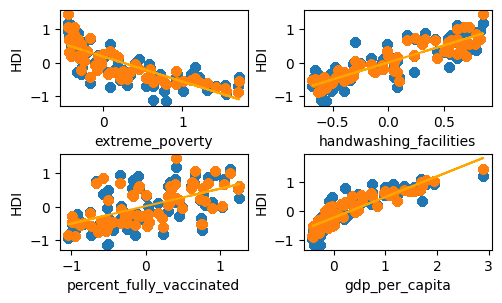

In [19]:
#a viz of the predicted vs trained data
plt.subplot(3, 2, 1)
a,b = np.polyfit(X_train[:, 0],y_pred,1)
plt.scatter(X_train[:, 0], y_train)
plt.scatter(X_train[:, 0],y_pred)
plt.plot(X_train[:, 0], a * X_train[:, 0] + b, color="orange")
plt.xlabel("extreme_poverty")
plt.ylabel("HDI")


plt.subplot(3, 2, 2)
a,b = np.polyfit(X_train[:, 1],y_pred,1)
plt.scatter(X_train[:, 1], y_train)
plt.scatter(X_train[:, 1],y_pred)
plt.plot(X_train[:, 1], a * X_train[:, 1] + b, color="orange")
plt.xlabel("handwashing_facilities")
plt.ylabel("HDI")

plt.subplot(3, 2, 3)
a,b = np.polyfit(X_train[:, 2],y_pred,1)
plt.scatter(X_train[:, 2], y_train)
plt.scatter(X_train[:, 2],y_pred)
plt.plot(X_train[:, 2], a * X_train[:, 2] + b, color="orange")
plt.xlabel("percent_fully_vaccinated")
plt.ylabel("HDI")


plt.subplot(3, 2, 4)
a,b = np.polyfit(X_train[:, 3],y_pred,1)
plt.scatter(X_train[:, 3], y_train)
plt.scatter(X_train[:, 3],y_pred)
plt.plot(X_train[:, 3], a * X_train[:, 3] + b, color="orange")
plt.xlabel("gdp_per_capita")
plt.ylabel("HDI")
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.8, top=0.9, wspace=0.3, hspace=0.5)

In [ ]:
print(X_train)

# Model Testing: Training Data

In [20]:
MSE = metrics.mean_squared_error(y_train, y_pred)
RMSE = np.sqrt(MSE)
pd.DataFrame([MSE, RMSE], index=['MSE', 'RMSE'], columns=['Metrics'])

,Metrics
MSE,0.056475
RMSE,0.237645


# Model Testing: Testing Data

In [21]:
X_test = x_scaler.transform(X_test)
y_test = y_scaler.transform(y_test)
y_pred= model.predict(X_test)

In [22]:
MSE = metrics.mean_squared_error(y_test, y_pred)
RMSE = np.sqrt(MSE)
pd.DataFrame([MSE, RMSE], index=['MSE', 'RMSE'], columns=['Metrics'])

,Metrics
MSE,0.055788
RMSE,0.236195


In [23]:
from sklearn.metrics import r2_score 
r2_score(y_test, y_pred)

0.8510744366129743

# Interpreting Predicting Values 

In [ ]:
y_pred

In [ ]:
y_pred = y_scaler.inverse_transform(y_pred)
y_pred